## TME 7 Chaine de Markov Caché
### Annotation de gènes par chaînes de Markov Caché

Les modeles de chaines de Markov caché sont tres utilisées notament dans les domaines de la reconnaisance de la parole, du traitement automatique du langage naturel, de la reconnaissance de l'écriture manuscrite et de la bioinformatique.

Les 3 problemes de bases des HMM (*Hidden Markov Model*) sont :
1. Évaluation : 
 -  Problème : calculer la probabilité d’observation de la séquence d’observations étant donnée un HMM:  
 -  Solution : *Forward Algorithm *

2. Décodage : 
 - Problème : trouver la séquence d’états qui maximise la séquence d’observations 
 - Solution : *Viterbi Algorithm *

3. Entraînement :  
 - Problème : ajuster les paramètres du modèle HMM afin de maximiser la probabilité de générer une séquence d’observations à partir de données d’entraînement  
  - Solution : *Forward-Backward Algorithm*
  

Dans ce TME, nous allons appliquer l'algorithme Viterbi a des données biologiques.

# Rappel de biologie

Dans ce TME nous allons voir comment les modèles statistiques peuvent être utilisés pour extraire de l'information des données biologiques brutes. Le but sera de spécifier des modèles de Markov cachées qui permettent d'annoter les positions des gènes dans le génome.

Le génome, support de l'information génétique, peut être vu comme une longue séquence de caractères écrite dans un alphabet à 4 lettres: A , C , G et T . Chaque lettre du génome est aussi appelée pair de base (ou bp). Il est maintenant relativement peu coûteux de séquencer un génome (quelques milliers d'euros pour un génome humain). Cependant on ne peut pas comprendre, simplement à partir de la suite de lettres, comment cette information est utilisée par la cellule (un peu comme avoir à disposition un manuel d'instructions écrit dans une langue inconnue).

Un élément essentiel est le gène, qui après transcription et traduction produira les protéines, les molécules responsables de la grande partie de l'activité biochimique des cellules.

La traduction en protéine est faite à l'aide du code génétique qui, à chaque groupe de 3 lettres (ou bp) transcrites fait correspondre un acide aminé. Ces groupes de 3 lettres sont appelés codon et il y en a 43, soit 64. Donc, en première approximation, un gène est défini par les propriétés suivantes (pour les organismes procaryotes):

- Le premier codon, appelé codon start est ATG,
- Il y a 61 codons qui codent pour la séquence d'acides aminés.
- Le dernier codon, appelé codon stop, marque la fin du gène et est l'une des trois séquences TAA , TAG ou TGA . Il n'apparaît pas dans le gène. 


Nous allons intégrer ces différents éléments d'information pour prédire les positions des gènes. Notez que pour simplifier nous avons omis le fait que la molécule d'ADN est constituée de deux brins complémentaires, et donc que les gènes présents sur le brin complémentaire sont vus "à l'envers" sur notre séquence. Les régions entre les gènes sont appelées les régions intergéniques . 

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

Chacune des séquences de gènes commence par un codon start et fini par un des codons stop. 

# Modélisation de gènes 
## Question 1 : Téléchargement des données

Nous travaillerons sur le premier million de bp du génome de E. coli (souche 042). Plutôt que de travailler avec les lettres A , C , G et T , nous allons les recoder avec des numéros (A =0, …, T =3). Les annontations fournies sont :
- 0 si la position est dans une region non codante = region intergenique
- 1 si la position correspond a la position 0 d'un codon
- 2 si la position correspond a la position 1 d'un codon
- 3 si la position correspond a la position 2 d'un codon

In [100]:
# Telechargez le fichier et ouvrez le avec pickle
import numpy as np
import pickle as pkl

Genome=np.load('genome.npy') # Le premier million de bp de E. coli
Annotation=np.load('annotation.npy')# L'annotation sur le genome

## On divise nos donnees, la moitie va nous sevir pour l'apprentissage du modèle
## l'autre partie pour son evaluation

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]


## Question 2 : Apprentissage 

Comme modèle le plus simple pour séparer les séquences de codons des séquences intergéniques, on va définir la chaîne de Markov caché dont le graphe de transition est donné ci dessous. 

![Image of Yaktocat](http://mapsi.lip6.fr/uploads/Cours/modele1.png)

Un tel modèle se défini de la manière suivante : nous considerons qu'il existe 4 états cachés possibles (intergénique, codon 0, codon 1, codon 2).

On peut rester dans les régions intergéniques, et quand on démarre un gène, la composition de chaque base du codon est différente. Il va falloir, afin de pouvoir utiliser ce modèle pour classifier, connaître les paramètres pour la matrice de transition (donc ici uniquement les probas $a$ et $b$), et les lois $(b_i,i=0,…,3)$ des observations pour les quatre états.

```python
Pi = np.array([1, 0, 0, 0])  ##on commence dans l'intergenique
A =  np.array([[1-a, a  , 0, 0], 
              [0  , 0  , 1, 0],
              [0  , 0  , 0, 1],
              [b  , 1-b, 0, 0 ]])
B = ...

```


Etant donné la structure d'un HMM (Hidden Markov Chain):

- les observations n'influencent pas les états: les matrices $\Pi$ (distribution de probabilité initiale), $A$ (matrice de transition) s'obtiennent comme dans un modèle de Markov simple (cf semaine 6)
- chaque observation ne dépend que de l'état courant 

La nature des données nous pousse à considérer des lois de probabilités discrètes quelconques pour les émissions. L'idée est donc de procéder par comptage en définissant la matrice $B$ (matrice de probabilités des émissions) comme suit:

- $K$ colonnes (nombre d'observations), $N$ lignes (nombre d'états)
- Chaque ligne correspond à une loi d'émission pour un état (ie, chaque ligne somme à 1) 

Ce qui donne l'algorithme:

1. $b_{ij}$ = comptage des émissions depuis l'état $s_i$ vers l'observation $x_j$
2. normalisation des lignes de $B$ 

Donner le code de la fonction `def learnHMM(allX, allS, N, K):` qui apprend un modèle à partir d'un ensemble de couples (seq. d'observations, seq. d'états) 

In [101]:
def learnHMM(allx, allq, N, K):
    """ apprend un modèle à partir 
    d'un ensemble de couples (seq. d'observations, seq. d'états) 
    retourne les matrices A  B """
    A = np.zeros((N, N)) 
    B = np.zeros((N, K))
    # Comptage
    for i_obs, i_st in zip(range(allx.shape[0]), range(allq.shape[0])):
        if i_st < allq.shape[0] - 1:
            A[allq[i_st], allq[i_st+1]] += 1
        B[allq[i_st], allx[i_obs]] += 1
        
    # Normalisation
    A = A / np.maximum(np.sum(A, axis=1).reshape(N, 1), 1)
    B = B / np.maximum(np.sum(B, axis=1).reshape(N, 1), 1)
    return A, B

In [102]:
Pi = np.array([1, 0, 0, 0])
nb_etat= 4 ## (intergénique, condon 0, codon 1, condon 2)
nb_observation = 4 ## (A,T,C,G)
A,B =learnHMM(genome_train, annotation_train, nb_etat, nb_observation)
print(A)
print(B)

[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]


Vous devez trouver 

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]```
$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]```
        
Notez que ce sont des matrices de probabilites, la somme de chaque ligne donne 1.

## Question 3 :  Estimation la séquence d'états par Viterbi

Il n'est pas toujours évident de trouver les régions codante et non codante d'un genome. Nous souhaiterions annonter automatiquement le genome, c'est à dire retrouver **la sequence d'état caché la plus probable** ayant permis de générer la séquence d'observation.

Rappels sur l'algorithme Viterbi (1967):

- Il sert à estimer la séquence d'états la plus probable étant donnés les observations et le modèle.
- Il peut servir à approximer la probabilité de la séquence d'observation étant donné le modèle. 

1\. Initialisation (avec les indices à 0 en python): 

$$\begin{array}{ccccccccc} \delta_{0} (i) &=& \log \pi_{i} +\log b_{i} (x_{1}) \\ \Psi_{0}(i) &=& -1 \mbox{ Note: -1 car non utilisé normalement} \end{array}$$

2\. Récursion: 

$$ \begin{array}{ccccccccc} \delta_{t} (j) &=&\displaystyle \left[\max_{i} \delta_{t-1}(i) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ \Psi_{t}(j) &=&\displaystyle \arg\max_{i\in [1,\ N]} \delta_{t-1} (i) + \log a_{ij} \end{array}$$

3\. Terminaison (indices à {$T-1$} en python) 

$$ S^{\star} = \max_{i} \delta_{T-1}(i)$$

4\. Chemin $$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{T-1}(i) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

L'estimation de $\log p(x_0^{T-1} | \lambda)$ est obtenue en cherchant la plus grande probabilité dans la dernière colonne de $\delta$. Donner le code de la méthode `viterbi(x,Pi,A,B):` 


In [103]:
def viterbi(allx,Pi,A,B):
    """
    Parameters
    ----------
    allx : array (T,)
        Sequence d'observations.
    Pi: array, (N,)
        Distribution de probabilite initiale
    A : array (N, N)
        Matrice de transition
    B : array (N, K)
        Matrice d'emission matrix

    """
    ## initialisation
    N = len(A)
    K = B.shape[1]
    T = len(allx)
    psi = np.zeros((N, T))
    psi[:, 0]= -1
    delta = np.zeros((N, T))
    delta[:, 0] = np.log(Pi) + np.log(B[:, allx[0]])
    
    ## recursion
    for t in range(1, T):
        delta[:, t] = np.max(delta[:, t-1].reshape(N, 1) + np.log(A), axis=0) + np.log(B[:, allx[t]])
        psi[:, t] = np.argmax(delta[:, t-1].reshape(N, 1) + np.log(A), axis=0)
    
    ## on remplit les états en utilisant une règle donnée
    predq = np.zeros_like(allx)
    predq[T-1] = np.argmax(delta[:, T-1])
    for t in range(T-2, -1, -1):
        predq[t] = psi[predq[t+1], t+1]
    
    return predq
    

In [104]:
etat_predits=viterbi(genome_test,Pi,A,B)
print(np.where(etat_predits != annotation_test, 0.0, 1.0).mean())
# On calcule ici le pourcentage de bonne classification; on voit qu'on prédit bien dans
# 54.069% de cas

/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


0.54069


## Affichage
On met les états cachés soit a 0 soit a 1, 0 pour non codant et 1 pour codant
```python
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1
```
puis on affiche pour position du génome si c'est une position codante ou non en utilisant les vrais annotations, puis on affiche pour chaque position si elle est predite comme codante ou non.
```python
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()
```

Vous pouvez considérer une sous partie du génome, par exemple entre 100000 et 200000. Commentez vos observations sur la qualité de la prédiction.

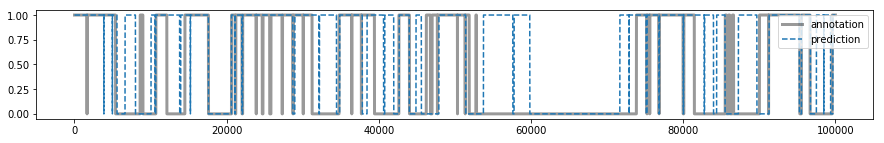

0.631682


In [105]:
etat_predits_cut = etat_predits[100000:200000]
annotation_test_cut = annotation_test[100000:200000]

etat_predits_cut[etat_predits_cut!=0] = 1
annotation_test_cut[annotation_test_cut!=0] = 1

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test_cut, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits_cut, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()

print(np.where(
          np.where(etat_predits != 0, 1, 0) != np.where(annotation_test != 0, 1, 0),
          0.0,
          1.0).mean())

# Des illustrations et du pourcentage de bonne classification on voit qu'on prédit bien pour
# un peu plus que la moitié des cas de l'échantillon de tests (54.069%).
# De plus, si on mesure seulement comment on a prédit des états "codant" ou "non codant",
# on verra que les résultats ne sont pas mal : on classifie bien dans 63.168% de cas.
# La classification donc n'est pas mal, par contre, on ne peut pas dire aussi qu'on
# classifie vraiment précisement.

## Question 4 :  Evaluation des performances

A partir des predictions et des vrai annotations du genome, dessiner la matrice de confusion. 

<img src="confusion.png" width="200">

Avec : 
- TP = True Positives, les régions codantes correctement prédictes,
- FP = False Positives, les régions intergénique prédites comme des régions codantes,
- TN = True Negatives, les régions intergeniques prédites correctement,
- FN = False Negatives, les régions codantes prédites comme non codantes.

L'état non codant est l'état 0, les autres (1,2,3) sont les états codants.

![](conf2.png)


In [26]:
def create_confusion_matrix(true_sequence, predicted_sequence):
    mat_conf = np.zeros((2, 2), dtype=int)
    # Comptage de confusions
    for true_s, pred_s in zip(true_sequence, predicted_sequence):
        if true_s != 0 and pred_s != 0:
            mat_conf[0, 0] += 1
        elif true_s == 0 and pred_s !=0:
            mat_conf[0, 1] += 1
        elif true_s != 0 and pred_s == 0:
            mat_conf[1, 0] += 1
        elif true_s == 0 and pred_s == 0:
            mat_conf[1, 1] += 1
    return mat_conf

Apres avoir créé la matrice de confusion, vous pouvez l'afficher en utilisant :

```python

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()
```

[[202819 152699]
 [ 31460 113022]]


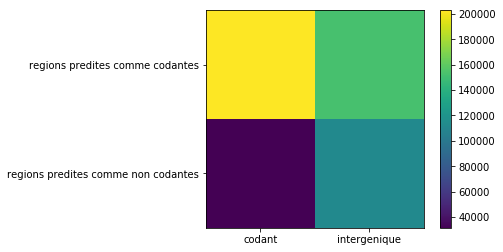

In [92]:
import matplotlib.pyplot as plt

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes'])

print(mat_conf)
plt.show()


Donner une interprétation.
Peut on utiliser ce model pour predir la position des genes dans le genome ?

In [28]:
# TP,FP=mat_conf[0] 
# FN,TN=mat_conf[1] 
# On vois donc qu'on classifie beaucoup des instances comme condantes tandis qu'elles sont 
# intergenique. En fait, on fait cela plus qu'on prédit bien pour des genes intergenique.
# Selon moi, on ne peut pas donc utiliser ce modèle parce que la probabilité de classifier
# un gène intergènique comme condant est supérieur que la probabilité de le classifier bien.

## Question 5 :  Generation de nouvelles sequences

En utilisant le model $ \lambda=\{Pi,A,B\}$ créer ` create_seq(N,Pi,A,B) ` une fonction permétant de générer
- une séquence d'état cachés
- une sequence d'observation.

In [29]:
def create_seq(N,Pi,A,B):
    '''
    Produire N états cachés en utilisant Pi et A
    
    et pour chaque état cachés produire une observation en utilisant B
    '''
    states, obs = np.zeros(N, dtype=int), np.zeros(N, dtype=int)

    rand_val = np.random.rand()
    states[0] = np.arange(len(Pi))[Pi.cumsum() > rand_val][0]
    
    rand_val = np.random.rand()
    obs[0] = np.arange(B.shape[1])[B[states[0]].cumsum() > rand_val][0]
    
    for i in range(1, N):
        rand_val = np.random.rand()
        states[i] = np.arange(len(Pi))[A[states[i-1]].cumsum() > rand_val][0]
        
        rand_val = np.random.rand()
        obs[i] = np.arange(B.shape[1])[B[states[i]].cumsum() > rand_val][0]
    
    return states, obs

# On teste une fonction écrit
# On voit que si on génére les états avec Pi donné et A calculée c'est pas du tout
# probable d'aller aux états 1, 2, 3
Pi = np.array([1.0, 0.0, 0.0, 0.0])
states, obs = create_seq(10, Pi, A, B)
print(states)
print(obs)
print('\n')

# Par contre, si on change Pi de telle façon pour ne commencer à générer par 0, on verra
# qu'on va presque jamais à 0
# Cela, c'est très cohérent avec une matrice A
Pi = np.array([0.0, 1.0, 0.0, 0.0])
states, obs = create_seq(10, Pi, A, B)
print(states)
print(obs)

[0 0 0 0 0 0 0 0 0 0]
[1 0 1 2 2 3 0 2 0 1]


[1 2 3 1 2 3 1 2 3 1]
[1 1 2 0 2 2 0 1 1 2]


## Question 6 : Construction d'un nouveau model

Evaluons maintenant si cela s'améliore en prenant en compte les frontières des gènes en construisant un modèle avec codon start et codon stop.
On veut maintenant d'intégrer l'information complémentaire qui dit qu'un gène commence "toujours" par un codon start et fini "toujours" par un codon stop avec le graphe de transition ci dessous.

On considere donc maintenant un modele avec 12 états cachés.
![](modele2.png)


- Ecrivez la matrice de transition correspondante, en mettant les probabilités de transition entre lettres pour les codons stop à 0.5.


- Adaptez la matrice des émissions pour tous les états du modèle. Vous pouvez reutiliser la matrice B, calculée précédement. Les états correspondant au codons stop n'émettrons qu'une seule lettre avec une probabilité 1.
Pour le codon start, on sait que les proportions sont les suivantes: ATG : 83% GTG: 14%, et TTG: 3%

```python
Pi2 = np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])  ##on commence encore dans l'intergenique
A2 =  np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                  ... ])
B2 = ...

```


Evaluez les performances du nouveau modèle en faisant de nouvelles predictions d'annotation pour genome_test, et comparez les avec le modèle précédent. 
```
etat_predits2=viterbi(genome_test,Pi2,A2,B2)
etat_predits2[etat_predits2!=0]=1 
```

```python

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()
```

Calculer la matrice de confusion pour avec les nouvelles predictions.

/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/Users/ivankachaikin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Pourcentage de bonne classification : 64.036%
Pourcentage de bonne classification pour "codant" / "non codant" : 66.604%


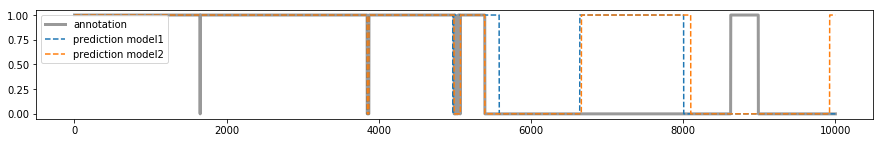

In [99]:
# Pour qu'on puisse ajouter des états dans notre modèle il faut créer une nouvelle échantillon
# pour les états cachés à partir d'une échantillon des gènes
# On va utiliser une notation suivante pour ces états :
# - 0 si la position est dans une region non codante = region intergenique
# - 1 si la position correspond à la position 0 d'un codon "start"
# - 2 si la position correspond à la position 1 d'un codon "start"
# - 3 si la position correspond à la position 2 d'un codon "start"
# - 4 si la position correspond à la position 0 d'un codon
# - 5 si la position correspond à la position 1 d'un codon
# - 6 si la position correspond à la position 2 d'un codon
# - 7 si la position correspond à la position 0 d'un codon "stop"
# - 8 si la position correspond à la position 1 d'un codon "stop" de valeur A
# - 9 si la position correspond à la position 1 d'un codon "stop" de valeur G
# - 10 si la position correspond à la position 2 d'un codon "stop" de valeur A
# - 11 si la position correspond à la position 2 d'un codon "stop" de valeur G

# fonction qui crée une nouvelle échantillon améliorée
def create_ann_improved(genome, annotation):
    
    # initialisation
    annotation_improved = np.zeros_like(genome)
    codon_started = False
    i = 0
    
    # parcours de toutes les valeurs dans le génome
    while i < genome.size:
        if annotation[i] == 0:
            i += 1
            continue
        # on cherche un codon "start"
        if i + 2 < genome.size and not codon_started:
            if (genome[i] == 0 or genome[i] == 2 or genome[i] == 3) and genome[i + 1] == 3 and genome[i + 2] == 2:
                codon_started = True
                annotation_improved[i] = 1
                annotation_improved[i + 1] = 2
                annotation_improved[i + 2] = 3
                i += 3
        # à partir d'un codon "start" on parcourt via tous les codon en cherchant un codon "stop"
        if codon_started and i + 2 < genome.size:
            condition_of_codon_stop = (genome[i] == 3 and
                                       genome[i + 1] == 2 and
                                       genome[i + 2] == 0 or
                                       genome[i] == 3 and
                                       genome[i + 1] == 0 and
                                       genome[i + 2] == 0 or
                                       genome[i] == 3 and
                                       genome[i + 1] == 0 and
                                       genome[i + 2] == 2
                                       )
            if condition_of_codon_stop:
                codon_started = False
                annotation_improved[i] = 7
                annotation_improved[i + 1] = 8 if genome[i + 1] == 0 else 9
                annotation_improved[i + 2] = 10 if genome[i + 2] == 0 else 11
                i += 2
            else:
                annotation_improved[i] = 4
                annotation_improved[i + 1] = 5
                annotation_improved[i + 2] = 6
                i += 2
        i += 1

    return annotation_improved

# à partir des échantllons initiales on crée des échantillons améliorées
annotation_train_improved = create_ann_improved(genome_train, annotation_train)
annotation_test_improved = create_ann_improved(genome_test, annotation_test)

# on répète toutes les actions des parties précédentes pour les nouvelles données
Pi2 = np.zeros(12)
Pi2[0] = 1.0
nb_etats_2, nb_obs_2 = 12, 4
A2, B2 = learnHMM(genome_train, annotation_train_improved, nb_etats_2, nb_obs_2)
# print(A)
# print(B)

# On peut observer qu'on a amélioré nos résultats un peu (64.036% vs. 54.069% et 66.604% vs. 63.168%)
etat_predits_2 = viterbi(genome_test, Pi2, A2, B2)
print('Pourcentage de bonne classification : %.3f%%' % 
      (np.where(etat_predits_2 != annotation_test_improved, 0.0, 1.0).mean() * 100))
print('Pourcentage de bonne classification pour "codant" / "non codant" : %.3f%%' % 
      (np.where(
          np.where(etat_predits_2 != 0, 1, 0) != np.where(annotation_test_improved != 0, 1, 0),
          0.0,
          1.0).mean() * 100))

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(np.where(annotation_test_improved != 0, 1, 0)[100000:110000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(np.where(etat_predits != 0, 1, 0)[100000:110000], label="prediction model1", ls="--")
ax.plot(np.where(etat_predits_2 != 0, 1, 0)[100000:110000], label="prediction model2", ls="--")
plt.legend(loc="best")
plt.show()

[[204509 147667]
 [ 26074 121750]]


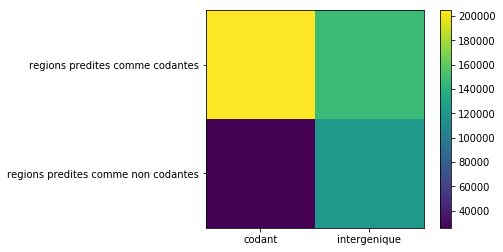

In [106]:
mat_conf = create_confusion_matrix(annotation_test_improved, etat_predits_2)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique'])
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes'])

print(mat_conf)
plt.show()

# Ici on voit aussi une petite amélioration du résultat

In [ ]:
# Pour conclure, c'est clair que introduisant certains nouveaux états cachés on a une possibilité
# d'améliorer un peu la qualité d'une prédiction
# Par contre, je trouve qu'on ne peut pas utiliser quand même ce modèle 
# car il produit encore beaucoup des erreurs essayant de prévoir un état "intergenique"